# Regularization

We could state in the last chapter that more complex models are not automatically better than simpler models. A special challenge when using more complex models is to train them in such a way that they do not only produce good results for training data but also for test data. The latter is especially important for the identification of general relationships. The more complex the relationship that models can represent, the more the danger is that the models are overfitted to the training data. Considering that the observations in the data are composed partly by a deterministic relationship and partly by random deviations, it may happen that the random deviation of the training data is also learned by the model. By definition, the random deviations for new data will be different from those in the training data, causing the model to generate sometimes wildly different predictions. This property is called overfitting and is strongly related to the higher variance of estimators of complex models. Moreover, models become more flexible not only with more complex functional form, but also with the inclusion of many variables. If we think of the polynomial regression of the last chapter, the inclusion of the polynomial of a higher degree increases by the same number of independent variables already in the model. To avoid having to manually select the level of flexibility of the model, but to train the level of flexibility along with the training of the model, there are several techniques that can generally be referred to as regularization of the model. Intuitively, regularization can be thought of as a manipulation of the training process that prevents the model from being too specific to the training data and thus helps to improve the generalization of the model.

## $L_1$ and $L_2$ Regularization

As in the previous chapters, we will discuss the principle of regularization using a concrete technique. We focus on the $L_1$ and $L_2$ regularization of the regression model. To do this, we briefly recall the common loss function of the linear regression model, the MSE:

$$
L\left(\boldsymbol{y}, f_{\boldsymbol{\beta}}(\boldsymbol{X}) \right) = \sum_{i=1}^n \left(y_i - \boldsymbol{\beta}^T \boldsymbol{x}_i \right)^2
$$

In the $L_1$ regularization of the linear regression model, the loss function changes to:

$$
L\left(\boldsymbol{y}, f_{\boldsymbol{\beta}}(\boldsymbol{X}) \right) = \sum_{i=1}^n \left(y_i - \boldsymbol{\beta}^T \boldsymbol{x}_i \right)^2 + \gamma \sum_{j = 1}^p | \beta_j | 
$$

Hereby, $\gamma$ is a hyperparameter which must be set by the user and $\sum_{q = 1}^p | \beta_q | 1$ is the $L_1$ norm of the parameter vector without $\beta_0$. If a linear regression model is trained using this loss function, it is also called Lasso Regression. An alternative to this is ridge regression, in which the loss function:

$$
L\left(\boldsymbol{y}, f_{\boldsymbol{\beta}}(\boldsymbol{X}) \right) = \sum_{i=1}^n \left(y_i - \boldsymbol{\beta}^T \boldsymbol{x}_i \right)^2 + \gamma \sum_{j = 1}^p  \beta_j^2
$$

is used to estimate the parameter vector. As the weight $\gamma$ increases, the parameters are pulled more and more towards $0$, which is why this type of regularization is also called shrinkage. In Lasso Regression, the variables with the least improvement (minimizing the loss function) are first given a parameter value close to or equal to $0$, which can thus be understood as automatic variable selection. Ridge regression tends to shift all parameters toward $0$ at the same time. In the bottom cell, we look at the estimated parameters of the regression model for the Advertising dataset. In the model, in addition to the original variables $x_{\text{TV}}$, $x_{\text{radio}}$, $x_{\text{newspaper}}$, we also included all possible interaction terms of these variables as well as the squared independent variables. In addition, all variables were standardized to better compare the estimated parameters. For both regularization types, it can be seen that the variables $x_{\text{TV}}$, $x_{\text{TV}}^2$ and $x_{\text{TV}} x_{\text{radio}}$ are the most important. However, we can also see that in Lasso Regression, as the weight of the regularization of these three variables increases, the variable $x_{\text{TV}}^2$ would be removed from the model first, by the parameter going towards $0$. In comparison, in ridge regression the influence of $x_{\text{TV}}$ and $x_{\text{TV}}^2$ is reduced almost in a symmetric way. 

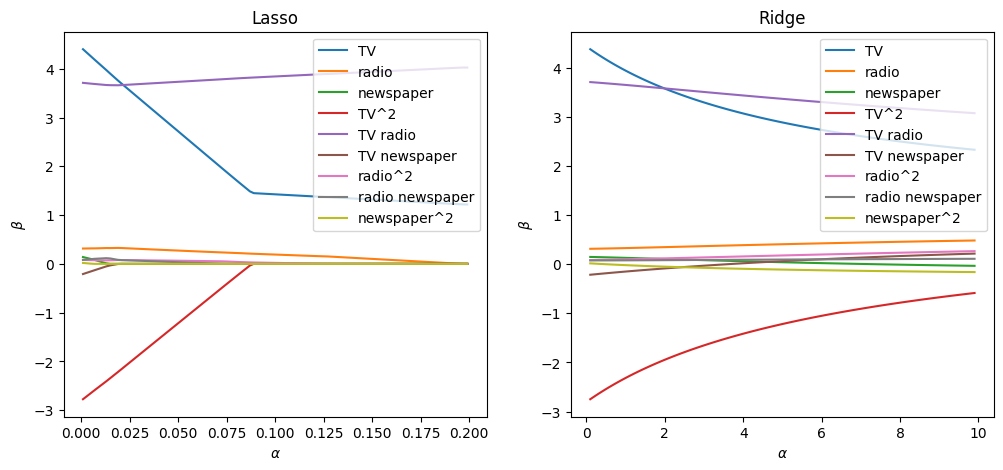

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pylab as plt


advertising_df = pd.read_csv("../data/Advertising.csv", index_col= "Unnamed: 0")
advertising_df.reset_index(drop = True, inplace = True)
X = advertising_df.drop(["sales"], axis = 1)
y = advertising_df.sales
polynomial_transformer = PolynomialFeatures(degree = 2, include_bias=False)
X_poly = pd.DataFrame(polynomial_transformer.fit_transform(X))
X_poly.columns = polynomial_transformer.get_feature_names_out()
X_poly = (X_poly - X_poly.mean()) / X_poly.std()

alpha_lasso = np.arange(0.001, 0.2, 0.002)
lasso_coefs = []
for alpha in alpha_lasso:
    lasso = Lasso(alpha = alpha)
    lasso.fit(X_poly, y)
    lasso_coefs.append(lasso.coef_)

alpha_ridge = np.arange(0.1, 10, 0.1)
ridge_coefs = []
for alpha in alpha_ridge:
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_poly, y)
    ridge_coefs.append(ridge.coef_)


lasso_df = pd.DataFrame(np.array(lasso_coefs), columns = X_poly.columns)
lasso_df.loc[:, "alpha"] = alpha_lasso
ridge_df = pd.DataFrame(np.array(ridge_coefs), columns = X_poly.columns)
ridge_df.loc[:, "alpha"] = alpha_ridge

fig, axs = plt.subplots(1, 2, figsize = (12, 5))

lasso_df.plot(x = "alpha", ax = axs[0], title = "Lasso")
ridge_df.plot(x = "alpha", ax = axs[1], title = "Ridge")
axs[0].set_xlabel(r"$\alpha$")
axs[1].set_xlabel(r"$\alpha$")
axs[0].set_ylabel(r"$\beta$")
axs[1].set_ylabel(r"$\beta$")
plt.show()

To demonstrate the positive impact on the performance of the model, we return to the synthetic example of the last chapter, where the polynomial regression model with degree $q = 12$ generated on average much higher deviations between prediction and realization for the test data than for the training data. In the bottom cell, we again use this model, but we train it in comparison with an $L_1$ regularization. As you can see, the result of the test data improves significantly and also graphically we can see that the regularized model clearly better represents the actual relationship.

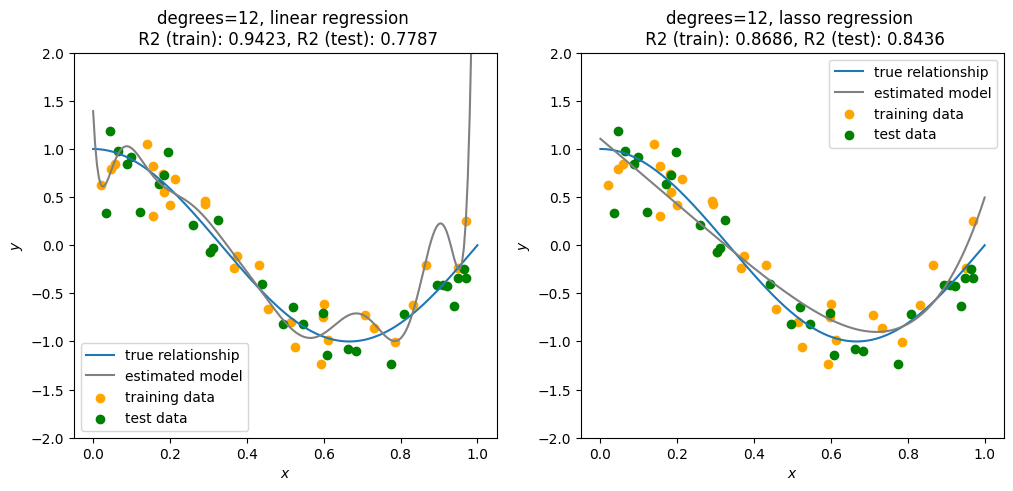

In [2]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score

# let us define a true functional relationship which is more complex than a simple linear relationship
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

# generate some sample data
np.random.seed(42)

n_samples = 30
degrees = [1, 4, 15]

# these values are for plotting the function
X_range = np.linspace(0, 1, 200)
# some training and some test data samples
X_train = np.sort(np.random.rand(n_samples))
X_test = np.sort(np.random.rand(n_samples))
y_train = true_fun(X_train) + np.random.randn(n_samples) * 0.25
y_test = true_fun(X_test) + np.random.randn(n_samples) * 0.25


def plot_poly_regression(degrees, sklearn_linear_model, main_title, ax = None):
    if ax == None:
        ax = plt.gca()

    polynomial_features = PolynomialFeatures(degree=degrees, include_bias=False)
    X_poly = polynomial_features.fit_transform(X_train.reshape(-1, 1))
    regression_model = sklearn_linear_model
    regression_model.fit(X_poly, y_train)

    ax.plot(X_range, true_fun(X_range), label = 'true relationship')
    ax.plot(X_range, regression_model.predict(polynomial_features.transform(X_range.reshape(-1, 1))), label = 'estimated model', color = 'grey')
    ax.scatter(X_train, y_train, label = 'training data', color = 'orange')
    ax.scatter(X_test, y_test, label = 'test data', color = 'green')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_ylim(-2, 2)
    ax.legend()
    r2_train = r2_score(y_train, regression_model.predict(polynomial_features.transform(X_train.reshape(-1, 1))))
    r2_test = r2_score(y_test, regression_model.predict(polynomial_features.transform(X_test.reshape(-1, 1))))
    ax.set_title(f'{main_title} \n R2 (train): {r2_train:.4f}, R2 (test): {r2_test:.4f}')

    return ax


fig, axs = plt.subplots(1, 2, figsize = (12, 5))
plot_poly_regression(12, LinearRegression(), main_title = 'degrees=12, linear regression', ax = axs[0], )
plot_poly_regression(12, Lasso(alpha = 0.0025), main_title = 'degrees=12, lasso regression', ax = axs[1])
plt.show()

# Choice of the tuning parameter

So far, we have not talked about the strength to which regularization should be included when estimating the model. This is determined by the choice of the $\alpha$ parameter. This is a parameter that is not trained by the data, but must be determined externally. It is therefore referred to as a hyperparameter. One way to determine this is to try different values for $\alpha$ and use the value that generates the lowest test error. However, two aspects have to be considered critically. When the information from the test data is used to optimize the hyperparameter, we have not evaluated performance of the final model, which exists independently of the information from known data. Moreover, the aspects mentioned in the penultimate chapter also apply to this evaluation of model performance, which is why some form of cross-validation is preferable to simply splitting the data. For a data set, it is advisable to first keep a part of the data and to perform a K-fold cross-validation for different values of $\alpha$ with the remaining data. The best value of $alpha$ can then be used to train the model again with all the data and then evaluate this model using the retained data. Repeating and splitting the (withheld) data differently, may result in different best values for $\alpha$. However, this potentially gives further insight into how sensitive the best value for $\alpha$ is to different samples.